# Importing and preprocessing of data

In [1]:

from google.colab import drive

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
TXTS_PATH = '/content/drive/My Drive/Becode/Kpmg/selection_fr'

In [3]:
import os

In [4]:
import pandas as pd
pd.set_option('display.max_colwidth', 255)

In [5]:
KPMG_PATH = '/content/drive/My Drive/Becode/Kpmg'
RESPONSES_PATH = '/content/drive/My Drive/Becode/Kpmg/responses_2018_now.json'

In [6]:
txt_filenames = [f for f in os.listdir(TXTS_PATH) if f.endswith(".txt")]

In [7]:
#reading json file to retrieve tags
responses = pd.read_json(RESPONSES_PATH)

In [8]:
#filtering only relevant columns
columns = ['jcId', 'jcFr', 'titleFr', 'themesFr', 'scopeFr', 'noScopeFr', 'documentLink']
responses2 = responses.copy(deep=True).loc[:,columns]
#getting txt_name from original pdf name
responses2["txt_name"] = responses2["documentLink"]
responses2["txt_name"] = responses2["txt_name"].str.replace("/","-")
responses2["txt_name"] = responses2["txt_name"].str.replace(".pdf","_FR.txt")
#filtering json only for selected files and columns
columns += ['txt_name']
responses2 = responses2.loc[responses2.txt_name.isin(txt_filenames), columns]
responses2.head(2)

,jcId,jcFr,titleFr,themesFr,scopeFr,noScopeFr,documentLink,txt_name
34,1110000,"COMMISSION PARITAIRE DES CONSTRUCTIONS METALLIQUE, MECANIQUE ET ELECTRIQUE","modification du régime de pension sectoriel social, du règlement de pension et du règlement de solidarité",[PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES],None,"[les employeurs et ouvriers des entreprises exemptées du paiement d'une cotisation pour le régime de pension sectorielsur la base d'un accord d'entreprise relatif à l'instauration ou à l'élargissement d'un régime de pension complémentaire, employeurs ...",111/111-2018-013525.pdf,111-111-2018-013525_FR.txt
35,1110000,"COMMISSION PARITAIRE DES CONSTRUCTIONS METALLIQUE, MECANIQUE ET ELECTRIQUE",allocation spéciale compensatoire,[PRIME SYNDICALE],None,None,111/111-2018-012196.pdf,111-111-2018-012196_FR.txt


In [9]:
#generating all possible FR themes
themes_fr = []
for r in  responses2.themesFr:
    if r is not None:
        for t in r:
            if t not in themes_fr:
                themes_fr += [t]
len(themes_fr)


54

In [10]:
#code to retrieve the entire body
#%%
for filename in responses2.txt_name.to_list():
    # filename = responses2.txt_name.to_list()[10] #test
    file_path = os.path.join(TXTS_PATH, filename)
    with open(file_path, 'r', encoding="utf8") as f:
        #to retrieve entire body not necessary
        responses2.loc[responses2.txt_name == filename, "doc_bodies"] = f.read()
        f.close()

In [11]:
t = themes_fr[0]
mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)

In [12]:
len(responses2)

578

In [13]:
 #len(responses2.dropna(axis=0, subset=['themesFr'])[map])

# Regex extraction
[RegEx Match Object](https://www.w3schools.com/python/gloss_python_regex_match.asp)

In [14]:
"""This script regex-extracts information from the document bodies to new DataFrame columns"""
#redundant libraries to be checked
import datetime
from pickle import load
import re

import numpy as np
import pandas as pd

In [15]:
df = responses2.head(5)

In [18]:
def split_func(text):
  texts_lst = []
  sents = text.split("\n\n")
  for sent in sents:
    texts_lst.append(sent)
  return texts_lst

In [19]:
df['texts_lst'] = df["doc_bodies"].apply(split_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
# generic function not working due to lambda issues
def extract_pattern(lst, pattern:str):
  output_lst = []
  for item in lst: 
    if re.search(pattern, item, flags=re.IGNORECASE):
      output_lst.append(item)
    else:
      pass
  return '\n'.join(output_lst)

In [21]:
# not precise extraction to be improved
def extract_scope(lst):
  output_lst = []
  for item in lst: 
    #pattern1 = r".*\b(convention collective de travail s'applique | Champ d'application)\b.*"
    #pattern2 = r".*\b(La présente convention collective de travail\s*\S* [a-z]'appli\w*)\b.*"
    #pattern3 = r".*\b(convention collective de travail|CCT)\s*\S*[a-z]('appli\w*)\b.*"
    #pattern4 = r".*\b(convention collective de travail|CCT)\s*\S*.*('?appli\w*)\b.*"
    #pattern = r".*\b(convention collective de.*travail|CCT).*('*appli\w*)\b.*"
    #pattern = r".*((convention collective de )(travail|CCT))*.*"
    pattern = r".*(convention collective de )(travail|CCT).*"
    if re.search(pattern, item, flags=re.IGNORECASE):
      output_lst.append(item)
    else:
      pass
  return '\n'.join(output_lst)

In [22]:
df['scopeFr'] = df['texts_lst'].apply(extract_scope)
df['scopeFr']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


34    CONVENTION COLLECTIVE DE TRAVAIL DU 17\n| de la présente convention collective de travail. "|  \n$4. Lorsqu'un employeur, dans le cadre d’un transfert | d'entreprise, d'établissement ou d'une partie d'entreprise ou d'établissement en conséquence d’un ...
35    Convention collective de travail du 15 octobre 2018 \nArticle 1er. - La présente convention collective de travail s'applique aux employeurs, aux ouvriers et aux ouvrières des entreprises ressortissant à la Commission paritaire des constructions métall...
36    Convention collective de travail du 15 octobre 2018 \nCONVENTION COLLECTIVE DE TRAVAIL\nLa présente convention collective de travail s'applique aux employeurs et aux ouvriers des entreprises de montage de ponts et de charpentes métalliques ressortissa...
37    Convention collective de travail du 3 septembre 2018 \nArticle 1”. La convention collective de travail s'applique aux employeurs et ouvriers (h/f) des entreprises établies dans la province d'Anvers ressortissant

In [23]:
def extract_deposit(lst):
  output_lst = []
  for item in lst: 
    pattern =r".*(épôt: )([0-9]{2})/([0-9]{2})/([0-9]{4}).*"
    match = re.search(pattern, item, flags=re.IGNORECASE)
    if match:
      output_str = str(match[2])+"/"+str(match[3])+"/"+str(match[4])
      output_lst.append(output_str)
    else:
      pass
  return '\n'.join(output_lst)

In [24]:
df['depotFr'] = df['texts_lst'].apply(extract_deposit)
df.loc[:,['txt_name','depotFr']]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,txt_name,depotFr
34,111-111-2018-013525_FR.txt,18/12/2018
35,111-111-2018-012196_FR.txt,
36,111-111-2018-012197_FR.txt,17/10/2018
37,111-111-2018-011427_FR.txt,05/09/2018
38,111-111-2018-009675_FR.txt,03/07/2018


In [25]:
def get_month_digit(month):
            dictionary = {
                'janvier': 1,
                'février': 2,
                'mars': 3,
                'avril': 4,
                'mai': 5,
                'juin': 6,
                'juillet': 7,
                'août': 8,
                'septembre': 9,
                'octobre': 10,
                'novembre': 11,
                'décembre': 12
            }            
            return dictionary[month]

In [26]:

def add_effective_date(df, body_column):
    """A function that searches the document bodies for fromDate and endDates
    and extracts datetime objects into new columns"""
    
    def get_dates(df_row):
        #start date matches ~46 out of 48 test cases
        #group 6 = month
        #group 7 = year
        pattern = r"((cette|la présente) (convention collective de travail|CCT)|elle).+(entre en vigueur|à partir|produit ses effets|s'étend|sort ses effets|prend cours|\bdéterminée|allant).{1,19}(le\b|du\b|de\b|au\b).{1,5}(janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) ([0-9]{4})"
        #pattern = r"(cette|la présente) (convention collective de travail|CCT|elle).+(entre en vigueur|à partir|produit ses effets|s'étend|sort ses effets|prend cours|\bdéterminée|allant).{1,19}(le\b|du\b|de\b|au\b).{1,5}(janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) ([0-9]{4})"
        #pattern = r"[cette|la présente] [convention collective de travail|CCT]|[elle].+[entre en vigueur|à partir|produit ses effets|s'étend|sort ses effets|prend cours|\bdéterminée|allant].{1,19}[le\b|du\b|de\b|au\b].{1,5}(janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) ([0-9]{4})"
        
        # finds the first instance of the regex in the body
        match = re.search(pattern, df_row[body_column], flags=re.IGNORECASE)
        if match:
            try:
                df_row['fromDate'] = datetime.date(int(match[7]), get_month_digit(match[6]), 1)
                #df_row['fromDate'] = datetime.date(int(match[6]), get_month_digit(match[5]), 1)
                #df_row['fromDate'] = datetime.date(int(match[1]), get_month_digit(match[0]), 1)
                #testing purpose fm
                print(match[0])
                print(match[1])
                print(match[2])
                print(match[3])
                print(match[4])
                print(match[5])
                print(match[6])
                #print(f'{type(match)}')
                #for i in range(10):
                #  print(match[i])
            except:
                pass
        else:
            df_row['fromDate'] = np.nan
            #df_row['fromDate'] = None
        
        #end date matches 47 of 48
        #group 6 = month
        #group 7 = year
        pattern = r"((cette|la présente) (convention collective de travail|CCT)|elle).+([0-9]{4}|cesse de produire ses effets|cesse d'être en vigueur|cesse ses effets|prend fin|expire|conclue jusq|prend.{1,25}fin).+(le\b|au\b).{1,5}(janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) ([0-9]{4})"
        #pattern = r"(cette|la présente) (convention collective de travail|CCT|elle).+([0-9]{4}|cesse de produire ses effets|cesse d'être en vigueur|cesse ses effets|prend fin|expire|conclue jusq|prend.{1,25}fin).+(le\b|au\b).{1,5}(janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) ([0-9]{4})"
        #pattern = r"[cette|la présente] [convention collective de travail|CCT)|elle].+[[0-9]{4}|cesse de produire ses effets|cesse d'être en vigueur|cesse ses effets|prend fin|expire|conclue jusq|prend.{1,25}fin].+[le\b|au\b].{1,5}(janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) ([0-9]{4})"
        #pattern = r"[cette|la présente] [convention collective de travail|CCT)|elle].+[[0-9]{4}|cesse de produire ses effets|cesse d'être en vigueur|cesse ses effets|prend fin|expire|conclue jusq|prend.{1,25}fin]"
        #pattern += r".+[le\b|au\b].{1,5}(janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) ([0-9]{4})"
        
        match = re.search(pattern, df_row[body_column], flags=re.IGNORECASE)
        if match:
            try:
                df_row['endDate'] = datetime.date(int(match[7]), get_month_digit(match[6]), 28)
                #df_row['endDate'] = datetime.date(int(match[6]), get_month_digit(match[5]), 28)
                #df_row['endDate'] = datetime.date(int(match[1]), get_month_digit(match[0]), 28)
                #testing purpose fm   
                #print(f'{type(match)}') 
                print(match[0])
                print(match[1])
                print(match[2])
                print(match[3])
                print(match[4])
                print(match[5])
                print(match[6])     
                #for i in range(10):
                #  print(match[i])
            except:
                pass
        else:
            df_row['endDate'] = np.nan
            #df_row['endDate'] = None
        
        #there might have been an erroneous match of endDate
        #which should be overwritten by None when durée idéterminée is detected
        pattern = r"((cette|la présente) (convention collective de travail|CCT)|elle).+(durée indéterminée|([0-9]{4}.+à l'exception))"
        match = re.search(pattern, df_row[body_column], flags=re.IGNORECASE)
        if match:
            df_row['endDate'] = np.nan
        
        return df_row
    
    df = df.apply(get_dates, axis=1)

    return df

In [27]:
responses2 = add_effective_date(responses2, "doc_bodies")
#responses2.loc[responses2.fromDate.isnull() == False,['txt_name','fromDate','endDate']]
responses2.loc[:,["txt_name","endDate","fromDate"]]

Streaming output truncated to the last 5000 lines.
au
décembre
La présente convention collective de travail prend cours le 22 mars 2018
La présente convention collective de travail
La présente
convention collective de travail
prend cours
le
mars
Cette convention collective de travail est conclue pour une durée déterminée : elle produit ses effets le 1 juillet 2019
Cette convention collective de travail
Cette
convention collective de travail
produit ses effets
le
juillet
Cette convention collective de travail est conclue pour une durée déterminée : elle produit ses effets le 1 juillet 2019 et prendra fin le 31 décembre 2019
Cette convention collective de travail
Cette
convention collective de travail
prendra fin
le
décembre
La présente convention collective de travail est conclue pour une durée déterminée et entre en vigueur le er janvier 2019
La présente convention collective de travail
La présente
convention collective de travail
entre en vigueur
le
janvier
elle, pour la période qui c

,txt_name,endDate,fromDate
34,111-111-2018-013525_FR.txt,NaN,2018-01-01
35,111-111-2018-012196_FR.txt,2018-12-28,2018-01-01
36,111-111-2018-012197_FR.txt,NaN,2018-07-01
37,111-111-2018-011427_FR.txt,NaN,NaN
38,111-111-2018-009675_FR.txt,NaN,2018-07-01
...,...,...,...
2801,310-310-2020-008512_FR.txt,NaN,2020-01-01
2802,310-310-2020-008513_FR.txt,2020-12-28,2019-01-01
2803,311-311-2020-011247_FR.txt,NaN,2020-01-01
2804,311-311-2020-002306_FR.txt,2020-12-28,2020-01-01


In [28]:
#Pendant la durée de cette CCT tous les jours de chômage temporaire ne seront pas pris en compte dans le calcul de la période de maximum soixante jours par année de article 2 de la CCT du 17 septembre 2019 conclue au sein de la Commission Paritaire de l’industrie chimique relative à la sécurité d'existence (numéro d'enregistrement 154419).



In [29]:
#extracting reference
#Pendant la durée de cette CCT tous les jours de chômage temporaire ne seront pas pris en compte dans le calcul de la période de maximum soixante jours par année de article 2 de la CCT du 17 septembre 2019 conclue au sein de la Commission Paritaire de l’industrie chimique relative à la sécurité d'existence (numéro d'enregistrement 154419).

def extract_reference(lst):
  output_lst = []
  for item in lst: 
    pattern =r".*(article )([0-9]{2}).*([0-9]{2}) (janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) ([0-9]{4}).*(numéro d'enregistrement)([0-9]{6}).*"
    match = re.search(pattern, item, flags=re.IGNORECASE)
    if match:
      output_str = "article "+str(match[2])+","+str(match[3])+"/"+get_month_digit(match[4])+"/"+str(match[5])+", n. "+match[7]
      output_lst.append(output_str)
    else:
      pass
  return '\n'.join(output_lst)


In [30]:
df['reference'] = df['texts_lst'].apply(extract_reference)
df['reference']

34    
35    
36    
37    
38    
Name: reference, dtype: object

In [31]:
def extract(df):
	'''overall regex extraction functioin'''

	df = add_scope(df)

	df = add_effective_date(df)

	return df

In [32]:
df =  add_effective_date(df, "doc_bodies")
#df.loc[:,['txt_name', 'texts_lst', 'depotFr', 'fromDate', 'endDate']]


La présente convention collective de travail, remplace à partir du 1” janvier 2018
La présente convention collective de travail
La présente
convention collective de travail
à partir
du
janvier
La présente convention collective de travail entre en vigueur le 1er janvier 2018
La présente convention collective de travail
La présente
convention collective de travail
entre en vigueur
le
janvier
La présente convention collective de travail entre en vigueur le 1er janvier 2018 pour les allocations afférentes à l'exercice 2018 et cesse d'être en vigueur le 31 décembre 2018
La présente convention collective de travail
La présente
convention collective de travail
cesse d'être en vigueur
le
décembre
La présente convention collective de travail produit ses effets le 1” juillet 2018
La présente convention collective de travail
La présente
convention collective de travail
produit ses effets
le
juillet
La présente convention collective de travail entre en vigueur le 1” juillet 2018
La présente conven

In [33]:
# wrap function not required
def add_tags(df, body_column):
  df['texts_lst'] = df[body_column].apply(split_func)
  #pattern1 = r".*\b(convention collective de travail s'applique | Champ d'application)\b.*
  #pattern2 = r".*\b(La présente convention collective de travail\s*\S* [a-z]'appli\w*)\b.*"
  #pattern3 = r".*\b(convention collective de travail|CCT)\s*\S*[a-z]('appli\w*)\b.*"
  #pattern4 = r".*\b(convention collective de travail|CCT)\s*\S*.*('?appli\w*)\b.*"
  #pattern = r".*\b(convention collective de.*travail|CCT).*('*appli\w*)\b.*"
  df['scopeFr'] = df['texts_lst'].apply(extract_scope)
  df['depotFr'] = df['texts_lst'].apply(extract_deposit)
  df.drop(columns=['texts_lst'], inplace = True)
  return df

# Preprocessing for NLP

In [34]:
from pandas import Series

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

# import entirely spacy to create Doc objects through nlp
import spacy
from spacy import load, lang

from wordcloud import WordCloud

from collections import Counter

from typing import List
from typing import Dict

# WARNINGS
# W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
# I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine

# GLOBAL VARIABLES
NAMED_ENTITIES = ['microsoft']

#testing
from os import getcwd as cwd
from os.path import dirname as dir
from os.path import join
import pandas as pd

In [35]:
def lemmatize(text_tokens: List[str]) -> List[str]:
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # Instantiate the WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    # Lemmatize all tokens into a new list: lemmatized
    texts_lemmatized = [wordnet_lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in text_tokens]
    return texts_lemmatized


def filter_words(texts_lemmatized: List[List[str]], freq_min=None, freq_max=None):
    frequency_absolute = Counter([item for elem in texts_lemmatized for item in elem])
    wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(frequency_absolute)
    frequency_relative = wordcloud.words_
    if freq_min is not None and freq_min > 0 and freq_min < 1:
        rel_freq_filtered = {k: v for k, v in frequency_relative.items() if v > freq_min}
    if freq_max is not None and freq_max > 0 and freq_max < 1:
        rel_freq_filtered = {k: v for k, v in frequency_relative.items() if v < freq_max}
    texts_filtered = [[t for t in pub_lem if t in rel_freq_filtered.keys()] for pub_lem in texts_lemmatized]
    # testing part
    f_abs_updated =Counter([ item for elem in texts_filtered for item in elem])   
    wordcloud_updated = WordCloud(width=1000, height=500).generate_from_frequencies(f_abs_updated)
    f_rel_updated = wordcloud_updated.words_
    return texts_filtered, f_abs_updated, f_rel_updated, wordcloud_updated


In [126]:
class Preprocess:
    def __init__(self, nlp_model='en_core_web_md'):
        self.nlp = load(nlp_model)
        if 'en_' in nlp_model:
          self.stop_words = lang.en.stop_words.STOP_WORDS
        elif 'fr_' in nlp_model:
          self.stop_words = lang.fr.stop_words.STOP_WORDS
        self.named_entities = set(NAMED_ENTITIES)

    def get_named_entities(self, texts: Series, inplace=True) -> set:
        # creating a single ner set
        nes = set()
        # function to extract NER from text
        def get_named_entities(text) -> set:
            doc = self.nlp(text)
            named_entities = set([ent.text for ent in doc.ents])
            return named_entities
        [[nes.add(n) for n in get_named_entities(text)] for text in texts]
        # adding predefined NER
        [nes.add(n) for n in self.named_entities]
        if inplace:
            self.named_entities = nes
        return nes

    def tokenize_text(self, text:str, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> List[str]:
        if stop_words is None:
            stop_words = self.stop_words
        if named_entities is None:
            named_entities = self.named_entities
        text = text.replace("\n", " ")
        # split string into words (tokens)
        tokens = word_tokenize(text.lower())
        # keep strings with only alphabets
        tokens = [t for t in tokens if t.isalpha()]
        tokens = lemmatize(tokens)
        # remove short words, they're probably not useful
        tokens = [t for t in tokens if len(t) > lenght_min]
        # remove stopwords
        tokens = [t for t in tokens if t not in stop_words]
        # remove NER not used
        tokens = [t for t in tokens if t not in named_entities]
        return tokens

    def clean_text(self, text:str, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> str:
        tokens = self.tokenize_text(text, stop_words, named_entities, lenght_min)
        text_cleaned = " ".join(tokens)
        return text_cleaned

    def tokenize_texts(self, texts:Series, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> List[List[str]]:
        texts_tokens = []
        nes = self.get_named_entities(texts, inplace=True)

        for text in texts:
            texts_tokens += [self.tokenize_text(text, stop_words, named_entities, lenght_min)]
        return texts_tokens

In [37]:
! python -m spacy download fr_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [38]:
import spacy
nlp = spacy.load('fr_core_news_md')

In [39]:
preprocess = Preprocess(nlp_model='fr_core_news_md')

In [40]:
# example of FR stopwords from the set
list(preprocess.stop_words)[:10]

['restant',
 'derniere',
 'parler',
 'ayant',
 'celles-là',
 'ceux-ci',
 'ouvert',
 'près',
 'vive',
 'avoir']

In [41]:
# importing nltk and downloading additional required packages
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [42]:
#cleaning text before extracting word clouds
responses2["bodies_cleaned"] = responses2["doc_bodies"].apply(preprocess.clean_text)

# Word cloud labelling

In [127]:
#preprocess all texts
all_ts = preprocess.tokenize_texts(responses2.bodies_cleaned)

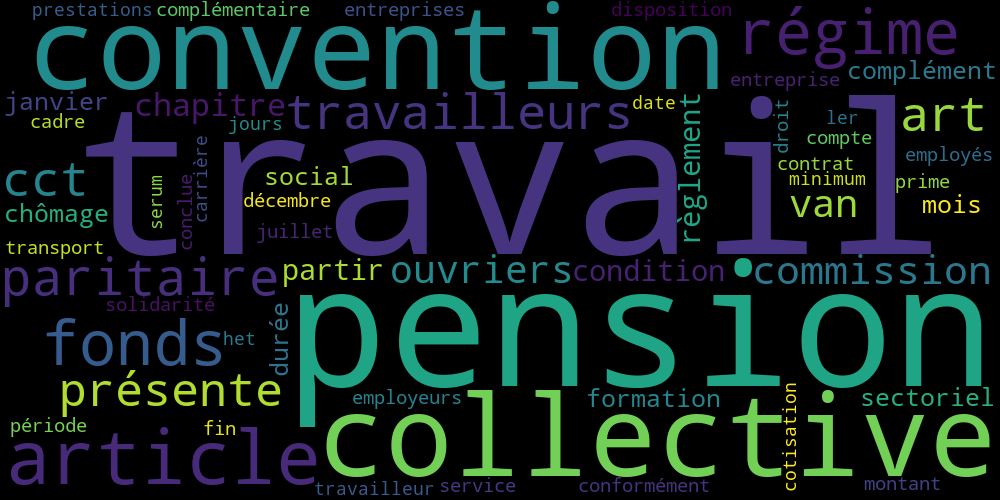

In [112]:
texts, f_abs, f_rel, wordcloud = filter_words(all_ts, freq_min=0.10)
wordcloud.to_image()

In [109]:
themes_tokenized = preprocess.tokenize_texts(themes_fr)
texts_themes, f_abs_themes, f_rel_themes, wordcloud_themes = filter_words(themes_tokenized, freq_max=0.5) 
themes_titles_keywords = [item for sublist in texts_themes for item in sublist]
themes_titles_keywords

['compémentaires',
 'assurance',
 'groupes',
 'équipe',
 'nuit',
 'pécule',
 'vacances',
 'propre',
 'secteur',
 'remboursement',
 'frais',
 'frais',
 'déplacement',
 'détachement',
 'fin',
 'salaires',
 'jeunes',
 'salaires',
 'formation',
 'excl',
 'formation',
 'compl',
 'prépension',
 'rcc',
 'économique',
 'employés',
 'complément',
 'rcc',
 'formation',
 'sécurité',
 'indemnités',
 'frais',
 'déplacement',
 'carrière',
 'emploi',
 'fin',
 'carrière',
 'recrutement',
 'groupes',
 'risque',
 'sociaux',
 'sécurité',
 'temporaire',
 'intérimaire',
 'temp',
 'heures',
 'modalités',
 'durée',
 'temp',
 'partiel',
 'ecochèques',
 'jour',
 'payé',
 'jour',
 'rtt',
 'compensation',
 'jour',
 'ferié',
 'paix',
 'sociale',
 'classification',
 'fonctions',
 'récompense',
 'alternative',
 'excl',
 'chèque',
 'bonus',
 'discrimination',
 'flexibilité',
 'temp',
 'heures',
 'supplémentaires',
 'harmonisation',
 'statut',
 'délégation',
 'fonctionnement',
 'organes',
 'concertation',
 'weekend',

In [125]:
stopwords_to_add = [w for w in list(preprocess.stop_words) if ((w in list(f_rel.keys())) & (w not in themes_titles_keywords))]
stopwords_to_add

['social',
 'transport',
 'travail',
 'art',
 'prestations',
 'serum',
 'conclue',
 'solidarité',
 'entreprises',
 'chapitre',
 'droit',
 'van',
 'mois',
 'condition',
 'disposition',
 'régime',
 'cotisation',
 'présente',
 'chômage',
 'het',
 'sectoriel',
 'partir',
 'ler',
 'montant',
 'conformément',
 'janvier',
 'cadre',
 'contrat',
 'cct',
 'employeurs',
 'pension',
 'service',
 'commission',
 'paritaire',
 'travailleurs',
 'compte',
 'collective',
 'prime',
 'ouvriers',
 'décembre',
 'juillet',
 'convention',
 'article',
 'travailleur',
 'fonds',
 'date',
 'complémentaire',
 'période',
 'minimum',
 'règlement']

In [113]:
# adding most frequent words as stop words
stopwords_to_add = 


[preprocess.stop_words.add(w) for w in list(f_rel.keys())]
[w for w in list(preprocess.stop_words) if ((w in list(f_rel.keys())) & (w not in themes_titles_keywords))]

['social',
 'transport',
 'travail',
 'art',
 'prestations',
 'serum',
 'conclue',
 'solidarité',
 'entreprises',
 'chapitre',
 'droit',
 'van',
 'mois',
 'condition',
 'disposition',
 'régime',
 'cotisation',
 'présente',
 'chômage',
 'het',
 'sectoriel',
 'partir',
 'ler',
 'montant',
 'conformément',
 'janvier',
 'cadre',
 'contrat',
 'cct',
 'employeurs',
 'pension',
 'service',
 'commission',
 'paritaire',
 'travailleurs',
 'compte',
 'collective',
 'prime',
 'ouvriers',
 'décembre',
 'juillet',
 'convention',
 'article',
 'travailleur',
 'fonds',
 'date',
 'complémentaire',
 'période',
 'minimum',
 'règlement']

In [120]:
stopwords_manual = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre', 
                    'national', 'loi', 'nombre', 'autant', 'niveau', 'numéro', 'vigueur']   
stopwords_list = [w for w in list(preprocess.stop_words) if (w in stopwords_manual)]


In [115]:
stopwords_list = [w for w in list(preprocess.stop_words) if ((w in list(f_rel.keys())) & (w not in themes_titles_keywords))]


In [122]:
themes_keywords = pd.DataFrame(columns=['themeFr', 'frequency_absolute', 'frequency_relative'])
for t in themes_fr:
  if t == "CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS)" or t == "RÉGIME DE CHÔMAGE AVEC COMPLÉMENT D'ENTREPRISE (RCC)":
    mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)
    r_t = responses2.dropna(axis=0, subset=['themesFr'])[mask]
    t_ts = preprocess.tokenize_texts(r_t["bodies_cleaned"])
    t_texts, t_f_abs, t_f_rel, t_wordcloud = filter_words(t_ts, freq_min=0.25, freq_max=0.75)
    themes_keywords = themes_keywords.append({'themeFr':t, 'frequency_absolute':t_f_abs, 'frequency_relative':t_f_rel, 'wordcloud': t_wordcloud}, ignore_index=True)
    print(f'Kewyords for {t} added, {len(r_t)} documents found')

Kewyords for CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS) added, 51 documents found
Kewyords for RÉGIME DE CHÔMAGE AVEC COMPLÉMENT D'ENTREPRISE (RCC) added, 114 documents found


CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS)


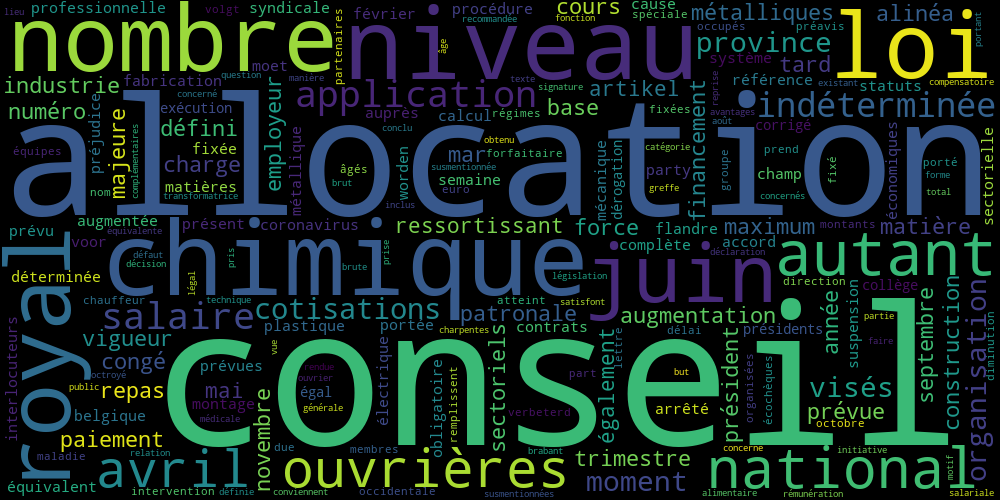

In [123]:
print(themes_keywords.loc[:,'themeFr'].values[0])
themes_keywords.loc[:,'wordcloud'].values[0].to_image()

RÉGIME DE CHÔMAGE AVEC COMPLÉMENT D'ENTREPRISE (RCC)


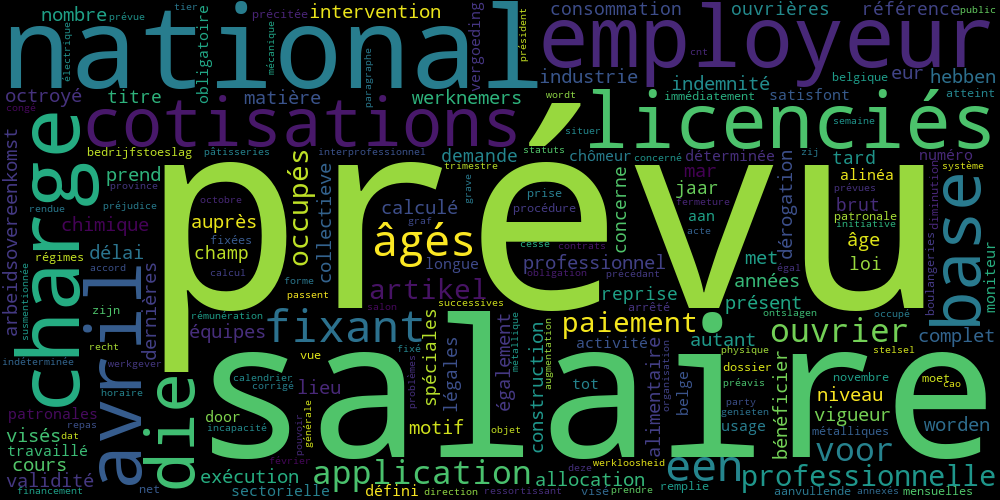

In [124]:
print(themes_keywords.loc[:,'themeFr'].values[1])
themes_keywords.loc[:,'wordcloud'].values[1].to_image()

In [72]:
#working
for index, row in themes_keywords.iterrows():
    print(row['themeFr'])
    row['wordcloud'].to_image()

PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES
PRIME SYNDICALE
TRAVAIL EN ÉQUIPE ET DE NUIT
PÉCULE DE VACANCES
PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE
REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT)
DÉTACHEMENT
PRIME DE FIN D'ANNÉE
SALAIRES
JEUNES TRAVAILLEURS: SALAIRES
FORMATION (EXCL. FORMATION SYNDICALE)
TRAVAILLEURS AGÉS-EXCL.PENSIONS COMPL, PRÉPENSION(RCC), CRÉDIT-TEMPS
MALADIE/ACCIDENT/DÉCÈS
CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS)
RÉGIME DE CHÔMAGE AVEC COMPLÉMENT D'ENTREPRISE (RCC)
FORMATION SYNDICALE
FONDS DE SÉCURITÉ D'EXISTENCE
INDEMNITÉS POUR FRAIS DE DÉPLACEMENT
CRÉDIT-TEMPS/DIMINUTION DE CARRIÈRE, EMPLOI FIN DE CARRIÈRE
RECRUTEMENT
GROUPES À RISQUE
BIEN-ÊTRE AU TRAVAIL
FONDS SOCIAUX, AUTRE QUE LES FONDS DE SÉCURITÉ D'EXISTENCE
TRAVAIL TEMPORAIRE ET TRAVAIL INTÉRIMAIRE
PRÉAVIS/LICENCIEMENT
TEMPS DE TRAVAIL EN HEURES
MODALITÉS DE LA DURÉE DE TRAVAIL
TRAVAIL À TEMPS PARTIEL
CHÈQUES-REPAS
ECOCHÈQUES
JOUR DE CONGÉ PAYÉ (PAS DE JOUR RTT OU DE COMPENSATION) ET 

In [49]:
for t in themes_fr:
  mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)
  r_t = responses2.dropna(axis=0, subset=['themesFr'])[mask]
  print(f'{len(r_t)} contained for {t}')

36 contained for PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES
20 contained for PRIME SYNDICALE
63 contained for TRAVAIL EN ÉQUIPE ET DE NUIT
6 contained for PÉCULE DE VACANCES
20 contained for PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE
23 contained for REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT)
18 contained for DÉTACHEMENT
37 contained for PRIME DE FIN D'ANNÉE
131 contained for SALAIRES
47 contained for JEUNES TRAVAILLEURS: SALAIRES
66 contained for FORMATION (EXCL. FORMATION SYNDICALE)
101 contained for TRAVAILLEURS AGÉS-EXCL.PENSIONS COMPL, PRÉPENSION(RCC), CRÉDIT-TEMPS
28 contained for MALADIE/ACCIDENT/DÉCÈS
51 contained for CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS)
114 contained for RÉGIME DE CHÔMAGE AVEC COMPLÉMENT D'ENTREPRISE (RCC)
16 contained for FORMATION SYNDICALE
66 contained for FONDS DE SÉCURITÉ D'EXISTENCE
57 contained for INDEMNITÉS POUR FRAIS DE DÉPLACEMENT
57 contained for CRÉDIT-TEMPS/DIMINUTION DE CARRIÈRE, EMPLOI FIN DE CARRIÈRE
16 contained fo

In [50]:
themes_keywords.to_csv('/content/drive/My Drive/Becode/Kpmg/labeling.csv')

In [51]:
themes_keywords.loc[:, ['themeFr','frequency_relative']]

,themeFr,frequency_relative
0,PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES,"{'règlement': 1.0, 'régime': 0.9255464480874317, 'solidarité': 0.7650273224043715, 'sectoriel': 0.7452185792349727, 'van': 0.6038251366120219, 'complémentaire': 0.5348360655737705, 'partir': 0.47062841530054644, 'ofp': 0.4603825136612022, 'métal': 0.4..."
1,PRIME SYNDICALE,"{'cotisation': 1.0, 'partir': 0.9342560553633218, 'travailleurs': 0.8062283737024222, 'entreprises': 0.6678200692041523, 'janvier': 0.6505190311418685, 'ouvriers': 0.6193771626297578, 'sécurité': 0.5986159169550173, 'formation': 0.5743944636678201, 'p..."
2,TRAVAIL EN ÉQUIPE ET DE NUIT,"{'ouvriers': 1.0, 'prime': 0.9102803738317757, 'minimum': 0.8336448598130841, 'salaires': 0.8299065420560747, 'mois': 0.8018691588785046, 'présente': 0.719626168224299, 'paritaire': 0.7046728971962617, 'commission': 0.6654205607476635, 'chapitre': 0.5..."
3,PÉCULE DE VACANCES,"{'art': 1.0, 'mois': 0.9375, 'juillet': 0.84375, 'chômage': 0.71875, 'vacances': 0.71875, 'travaux': 0.6875, 'paritaire': 0.59375, 'entreprises': 0.59375, 'commission': 0.5625, 'durée': 0.5625, 'sectoriels': 0.5625, 'pécule': 0.5625, 'période': 0.5312..."
4,PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE,"{'art': 1.0, 'salaires': 0.7081081081081081, 'minimum': 0.6432432432432432, 'salaire': 0.572972972972973, 'mois': 0.5351351351351351, 'chapitre': 0.5297297297297298, 'présente': 0.4486486486486487, 'heures': 0.4486486486486487, 'paritaire': 0.43783783..."
5,REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT),"{'art': 1.0, 'prime': 0.9, 'entreprises': 0.8, 'partir': 0.7666666666666667, 'ouvriers': 0.7333333333333333, 'service': 0.7066666666666667, 'chauffeur': 0.6866666666666666, 'paritaire': 0.68, 'jours': 0.6733333333333333, 'mois': 0.62, 'chapitre': 0.61..."
6,DÉTACHEMENT,"{'fonds': 1.0, 'janvier': 0.6819571865443425, 'paritaire': 0.6085626911314985, 'ouvriers': 0.599388379204893, 'travailleurs': 0.5902140672782875, 'commission': 0.5749235474006116, 'sécurité': 0.5626911314984709, 'van': 0.5596330275229358, 'durée': 0.5..."
7,PRIME DE FIN D'ANNÉE,"{'fin': 1.0, 'cct': 0.9055944055944056, 'présente': 0.7622377622377622, 'commission': 0.7447552447552448, 'paritaire': 0.7272727272727273, 'travailleurs': 0.6853146853146853, 'chômage': 0.6398601398601399, 'mois': 0.6293706293706294, 'jours': 0.625874..."
8,SALAIRES,"{'van': 1.0, 'ouvriers': 0.9033333333333333, 'paritaire': 0.8344444444444444, 'salaires': 0.82, 'travailleurs': 0.8133333333333334, 'minimum': 0.7855555555555556, 'commission': 0.7666666666666667, 'partir': 0.7644444444444445, 'présente': 0.7166666666..."
9,JEUNES TRAVAILLEURS: SALAIRES,"{'minimum': 1.0, 'salaires': 0.986870897155361, 'ouvriers': 0.949671772428884, 'chapitre': 0.687089715536105, 'mois': 0.6214442013129103, 'juillet': 0.6017505470459519, 'ler': 0.6017505470459519, 'euro': 0.5317286652078774, 'heures': 0.525164113785557..."


# Classification model

Themes tagging. Agreed to not assign enough time and resources to tackle all the following challenges:


1.   Some theme only present with other themes. Filtering by presence of a theme among the document themes.
1.    Lack of enough samples for some themes. Acceptance of different accuracy per theme.
1.   Lack of reliable true negatives (e.g. chomage temporaire). Use of multilabel classification checking similarities with corpus of theme docs.
1.   Selection of keywords per theme to be used avoding too many unecessary overlaps. Not enoug time for it.

In [52]:
dfa = responses2

In [53]:
#generating all possible FR themes (replacing previous list of 53 items)
themes_fr = []
for r in  dfa.themesFr:
    if r is not None:
        for t in r:
            if t not in themes_fr:
                themes_fr += [t]
themes_fr

['PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES',
 'PRIME SYNDICALE',
 'TRAVAIL EN ÉQUIPE ET DE NUIT',
 'PÉCULE DE VACANCES',
 "PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE",
 'REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT)',
 'DÉTACHEMENT',
 "PRIME DE FIN D'ANNÉE",
 'SALAIRES',
 'JEUNES TRAVAILLEURS: SALAIRES',
 'FORMATION (EXCL. FORMATION SYNDICALE)',
 'TRAVAILLEURS AGÉS-EXCL.PENSIONS COMPL, PRÉPENSION(RCC), CRÉDIT-TEMPS',
 'MALADIE/ACCIDENT/DÉCÈS',
 'CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS)',
 "RÉGIME DE CHÔMAGE AVEC COMPLÉMENT D'ENTREPRISE (RCC)",
 'FORMATION SYNDICALE',
 "FONDS DE SÉCURITÉ D'EXISTENCE",
 'INDEMNITÉS POUR FRAIS DE DÉPLACEMENT',
 'CRÉDIT-TEMPS/DIMINUTION DE CARRIÈRE, EMPLOI FIN DE CARRIÈRE',
 'RECRUTEMENT',
 'GROUPES À RISQUE',
 'BIEN-ÊTRE AU TRAVAIL',
 "FONDS SOCIAUX, AUTRE QUE LES FONDS DE SÉCURITÉ D'EXISTENCE",
 'TRAVAIL TEMPORAIRE ET TRAVAIL INTÉRIMAIRE',
 'PRÉAVIS/LICENCIEMENT',
 'TEMPS DE TRAVAIL EN HEURES',
 'MODALITÉS DE LA DURÉE DE TRAVAIL',


In [54]:
themes_statistics = pd.DataFrame(columns=['themeFr','part_of'])

for t in themes_fr:
  mask = dfa.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)
  r_t =dfa.dropna(axis=0, subset=['themesFr'])[mask]
  mask2 = r_t.themesFr.map(lambda x: len(x) == 1)
  r_t_u = r_t[mask2]
  themes_statistics = themes_statistics.append({'themeFr':t, 'part_of':len(r_t), 'unique':len(r_t_u)}, ignore_index=True)

themes_statistics = themes_statistics.append({'themeFr':None, 'part_of':None, 'unique':dfa.themesFr.isna().sum()}, ignore_index=True)

themes_statistics

,themeFr,part_of,unique
0,PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES,36,21.0
1,PRIME SYNDICALE,20,8.0
2,TRAVAIL EN ÉQUIPE ET DE NUIT,63,3.0
3,PÉCULE DE VACANCES,6,1.0
4,PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE,20,2.0
5,REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT),23,3.0
6,DÉTACHEMENT,18,0.0
7,PRIME DE FIN D'ANNÉE,37,16.0
8,SALAIRES,131,23.0
9,JEUNES TRAVAILLEURS: SALAIRES,47,2.0


In [55]:
# showing only 27 unique themes against 54 available
df.dropna(axis=0, subset=['themesFr'], inplace=True)
df['theme'] = df['themesFr'].apply(lambda x: x[0] if len(x) == 1 else None)
len(df.theme.unique())

4

In [56]:
from pickle import load

with open(os.path.join(KPMG_PATH, "clas_new.pkl"), 'rb') as f:
  df = load(f)

In [57]:
df.columns

Index(['depositNumber', 'displayJcId', 'titleFr', 'themesFr',
       'publicationDate', 'scopeFr', 'endDate', 'enforced', 'docBodyFr'],
      dtype='object')

In [58]:
df["body_cleaned"] = df["docBodyFr"].apply(preprocess.clean_text)

In [59]:
for t in themes_fr:
	df.dropna(axis=0, subset=['themesFr'], inplace=True)
	df[t] = df['themesFr'].apply(lambda x: 1 if t in x else 0)
df.columns

Index(['depositNumber', 'displayJcId', 'titleFr', 'themesFr',
       'publicationDate', 'scopeFr', 'endDate', 'enforced', 'docBodyFr',
       'body_cleaned', 'PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES',
       'PRIME SYNDICALE', 'TRAVAIL EN ÉQUIPE ET DE NUIT', 'PÉCULE DE VACANCES',
       'PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE',
       'REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT)', 'DÉTACHEMENT',
       'PRIME DE FIN D'ANNÉE', 'SALAIRES', 'JEUNES TRAVAILLEURS: SALAIRES',
       'FORMATION (EXCL. FORMATION SYNDICALE)',
       'TRAVAILLEURS AGÉS-EXCL.PENSIONS COMPL, PRÉPENSION(RCC), CRÉDIT-TEMPS',
       'MALADIE/ACCIDENT/DÉCÈS',
       'CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS)',
       'RÉGIME DE CHÔMAGE AVEC COMPLÉMENT D'ENTREPRISE (RCC)',
       'FORMATION SYNDICALE', 'FONDS DE SÉCURITÉ D'EXISTENCE',
       'INDEMNITÉS POUR FRAIS DE DÉPLACEMENT',
       'CRÉDIT-TEMPS/DIMINUTION DE CARRIÈRE, EMPLOI FIN DE CARRIÈRE',
       'RECRUTEMENT', 'GROUPES À RISQUE',